## Testing the limits of our visualization scheme

In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
import time


"""# modules specific to this project
from context import networker as nw
from context import physics
from context import timemarching as tm
from context import plotter
from context import logger"""

from dynamicnanobrain.core import networker as nw
from dynamicnanobrain.core import physics
from dynamicnanobrain.core import timemarching as tm
from dynamicnanobrain.core import plotter
from dynamicnanobrain.core import logger


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Define the broadcasting channels of the network
This is done by creating a list of the channel names. The names are arbitrary and can be set by the user, such as 'postive', 'negative' or explicit wavelenghts like '870 nm', '700 nm'. Here I chose the colors 'red' and 'blue'.

In [14]:
channel_list = ['red', 'blue']
# Automatically generate the object that handles them
channels = {channel_list[v] : v for v in range(len(channel_list))}
# It looks like this
print(channels)

{'red': 0, 'blue': 1}


### 2. Define the layers
Define the layers of nodes in terms of how they are connected to the channels. Layers and weights are organized in dictionaries. The input and output layers do not need to be changed, but for the hidden layer we need to specify the number of nodes N and assign the correct channels to the input/output of the node.

In [15]:
# Create layers ordered from 0 to P organized in a dictionary
layers = {} 
# An input layer automatically creates on node for each channel that we define
layers[0] = nw.InputLayer(N=2)
layers[1] = nw.HiddenLayer(N=10, output_channel='red',excitation_channel='blue',inhibition_channel='red')
layers[2] = nw.OutputLayer(N=2) # for now it can be the same as input

### 3. Define existing connections between layers
The weights are set in two steps. 
First the connetions between layers are defined. This should be done using the keys defined for each layer above, i.e. 0, 1, 2 ... for input, hidden and output layers, respectively. The `connect_layers` function returns a weight matrix object that we store under a chosen key, for example `'inp->hid'`.
Second, the specific connections on the node-to-node level are specified using the node index in each layer and the function `connect_nodes` of the weights object.

In [16]:
# Define the overall connectivity
weights = {}
# The syntax is connect_layers(from_layer, to_layer, layers, channels)
# Some blue channels
weights['inp->hid(blue)'] = nw.connect_layers(0, 1, layers, channel='blue')
weights['hid->out(blue)'] = nw.connect_layers(1, 2, layers, channel='blue')
# Recurrent connections possible
weights['hid->hid(blue)'] = nw.connect_layers(1, 1, layers, channel='blue')
# Some red channels
weights['inp->hid(red)'] = nw.connect_layers(0, 1, layers, channel='red')
weights['hid->out(red)'] = nw.connect_layers(1, 2, layers, channel='red')
# Recurrent connections possible
weights['hid->hid(red)'] = nw.connect_layers(1, 1, layers, channel='red')


# Generate random weights
import numpy as np
from numpy.random import default_rng

# This provides random weights between hidden layers. 
# This setup assumes mixed output from the nodes in the hidden layers, 
# which is beyond our main assumption that all nodes in the hidden layer are identical and thus
# should have the same input.
def random_W (N1,N2,channels,weight_density=0.5, weight_scale=1.0) :
    rng = default_rng()

    # Weight matrix between 0 and 1 is M x N2 x N1 (N nodes in hidden layer, M nr of channels)
    M = len(channels)
    W = np.zeros((M,N2,N1))
    for key in channels :
        for n2 in range(N2) :
            # Get two sequences of random numbers
            prop_weight = rng.uniform(size=N1)
            vals_weight = rng.uniform(size=N1)*weight_scale
        
            n_mask = (prop_weight < weight_density)
            W[channels[key],n2,n_mask] = vals_weight[n_mask]
        
    return W
            
def random_W_inout(N, channels, weight_density=0.5, weight_scale=1.0, W_type='in') :
    rng = default_rng()

    X = np.zeros(N)
    for key in channels :
        # Get two sequences of random numbers
        prop_weight = rng.uniform(size=N)
        vals_weight = rng.uniform(size=N)*weight_scale
        
        n_mask = (prop_weight < weight_density)
        X[n_mask] = vals_weight[n_mask]
        
    M = len(channels)
    if W_type == 'in' :
        W = np.zeros((M,N,M))
        for key in channels:
            W[channels[key],:,channels[key]] = X
    else :
        W = np.zeros((M,M,N))
        for key in channels:
            W[channels[key],channels[key],:] = X
            
    return W
    
# Set some random connections inp->hid
W = random_W_inout(layers[1].N,channels, weight_scale=2.0, W_type='in')
for key in channel_list :
    weights['inp->hid('+key+')'].set_W(W[channels[key]])
    weights['inp->hid('+key+')'].print_W()   
    
# Set some random connections hid->hid
#sub_channels = {'red':0} # Use this to limit the types of interconnections inside the layer.
sub_channels = channels
W = random_W(layers[1].N,layers[1].N,sub_channels, weight_scale=2.0)
for key in channel_list :
    weights['hid->hid('+key+')'].set_W(W[sub_channels[key]])
    weights['hid->hid('+key+')'].print_W() 

# Set some random connections hid->out
W = random_W_inout(layers[1].N,channels, weight_scale=2.0, W_type='out')
for key in channel_list :
    weights['hid->out('+key+')'].set_W(W[channels[key]])
    weights['hid->out('+key+')'].print_W()       


red:
[[0.     0.    ]
 [0.7271 0.    ]
 [0.     0.    ]
 [0.9183 0.    ]
 [1.4325 0.    ]
 [0.8763 0.    ]
 [0.611  0.    ]
 [0.     0.    ]
 [0.8467 0.    ]
 [1.1471 0.    ]]
blue:
[[0.     0.    ]
 [0.     0.7271]
 [0.     0.    ]
 [0.     0.9183]
 [0.     1.4325]
 [0.     0.8763]
 [0.     0.611 ]
 [0.     0.    ]
 [0.     0.8467]
 [0.     1.1471]]
red:
[[1.648  1.6096 0.     0.     1.2303 0.4178 0.     0.1824 0.     0.    ]
 [0.6469 0.0978 0.     0.     0.     0.8057 0.     0.3913 0.     0.5394]
 [0.2438 0.     1.5479 0.9886 0.9669 1.9657 0.     0.     0.9422 0.4729]
 [1.9268 0.     1.4655 0.     0.     1.6892 0.     1.1296 0.     0.    ]
 [0.     1.1374 1.3962 1.313  0.3551 0.7316 0.     1.7814 0.     0.    ]
 [0.263  0.     0.0995 1.997  0.     0.0388 0.     0.     1.5783 1.7556]
 [0.     0.6188 0.5291 1.7413 0.0882 1.8067 0.     0.     0.     1.6958]
 [0.     0.     0.     1.6801 0.     0.     1.489  1.238  0.     1.9676]
 [0.     1.9907 1.1599 0.     1.3346 0.     1.2374 0.     

### 4. Visualize the network 
The `plotter` module supplies functions to visualize the network structure. The nodes are named by the layer type (Input, Hidden or Output) and the index. To supress the printing of weight values on each connection, please supply `show_edge_labels=False`.

#### Available layouts:
**multipartite**: Standard neural network appearance. Hard to see recurrent couplings within layers.  
**circular**: Nodes drawn as a circle  
**shell**: Layers drawn as concetric circles  
**kamada_kawai**: Optimization to minimize weighted internode distance in graph  
**spring**: Spring layout which is standard in `networkx` 

#### Shell layout
This is my current favorite. It is configured to plot the input and output nodes on the outside of the hidden layer circle, in a combined outer concentric circle.

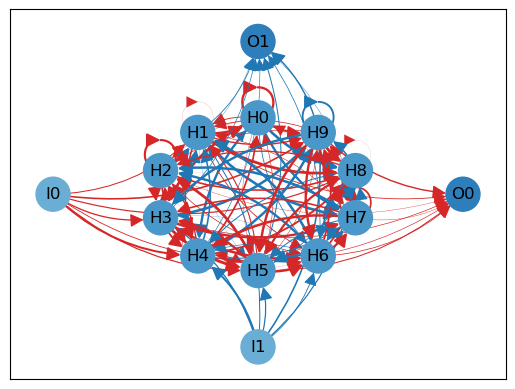

{'H0': array([-2.18556941e-08,  5.00000000e-01]),
 'H1': array([-0.29389262,  0.4045085 ]),
 'H2': array([-0.4755283,  0.1545084]),
 'H3': array([-0.47552827, -0.15450849]),
 'H4': array([-0.29389253, -0.40450856]),
 'H5': array([ 5.96244032e-09, -5.00000000e-01]),
 'H6': array([ 0.29389274, -0.40450841]),
 'H7': array([ 0.47552827, -0.15450847]),
 'H8': array([0.47552821, 0.15450865]),
 'H9': array([0.29389259, 0.40450853]),
 'I0': array([-1.00000000e+00, -8.74227766e-08]),
 'I1': array([ 1.19248806e-08, -1.00000000e+00]),
 'O0': array([1.00000000e+00, 1.74845553e-07]),
 'O1': array([-3.37766238e-07,  1.00000000e+00])}

In [17]:
plotter.visualize_network(layers, weights, layout='shell', show_edge_labels=False)